In [ ]:
# Mounting google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##**Importing important libraries and modules**

In [ ]:
# Importing important libraries regrading data manipulation, visualization, modelling and prediction
import os
import glob
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
from keras.models import Sequential, load_model
from keras.layers import Dropout, Dense, Conv2D, AveragePooling2D, Flatten
from keras.layers import BatchNormalization
from sklearn.metrics import accuracy_score, confusion_matrix
from google.colab.patches import cv2_imshow
import cv2
import PIL
import io
import html
import time
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode, b64encode
from google.colab import output
%matplotlib inline

##**Haar Cascade Classifier**

This model is going to be trained on images of eye open/closed and a person yawning/not yawning. Now while prediction there will be only one image of a person driving. So, there is a need to extract the images of his/her eyes separately so that we can predict on both the images (original and extracted one) and can make our decision more accurately. 

Now to extract images of eyes, we can use haar cascade classifier from OpenCv. Haar Cascade classifier is an effective object detection approach which was proposed by Paul Viola and Michael Jones in their paper, “Rapid Object Detection using a Boosted Cascade of Simple Features” in 2001.

This is basically a machine learning based approach where a cascade function is trained from a lot of images both positive and negative. Based on the training it is then used to detect the objects in the other images.

It works with the help of huge individual .xml files with a lot of feature sets and each xml corresponds to a very specific type of use case.

Here I have gone to the github page of haarcascade and downloaded a particular xml file containing the feature set to detect the eyes(open/closed) within a Image.

##**Uploading Xml file for haar cascade classifier in google drive**

In [ ]:
# I have already downloaded this xml file (haarcascade_lefteye_2splits.xml) from link: https://github.com/opencv/opencv/tree/master/data/haarcascades and saved the same on my desktop
# With the help of below code we can upload the xml file directly into drive
from google.colab import files
file = files.upload()

Saving haarcascade_lefteye_2splits.xml to haarcascade_lefteye_2splits.xml


##**Reading Data**

In [ ]:
# We have to read data from drive which I have uploaded and saved earlier. 
# The folder is named as 'train' and it contains 4 other folders namely -  Closed-1, Open-2, yawn-3 and no_yawn-4.
# First of all we will extract the detail of all the data from drive and save all of them in terms of dataframe with foldername, imagename, component and Labels

all_classes_detail=[]
r=0
classes = {1:'Closed_1', 2:'Open_2', 3:'yawn_3', 4:'no_yawn_4'}

# Looping through all the folders to collect details of data
while r<4:

  # Extracting foldername, imagename, component and labelling 
  Class_detail = glob.glob("../content/drive/My Drive/Project_new/train/" + classes[r+1] + "/*")
  print("\nNumber of images in "+(classes[r+1])[:len(classes[r+1])-2]+" class = "+str(len(Class_detail)))
  class_folderName = [str(i.split("n/")[0])+"n/"+classes[r+1]+"/" for i in Class_detail]
  class_imageName = [str(i.split("/")[7]) for i in Class_detail]
  class_component = [[(classes[r+1])[:len(classes[r+1])-2]]*len(Class_detail)][0]
  class_label = [r+1]*len(Class_detail)

  # Defining dataframe and saving all the extracted information corresponding to each class in that dataframe
  d_f = pd.DataFrame() 
  d_f["folderName"] = class_folderName
  d_f["imageName"] = class_imageName
  d_f["Component"] = class_component
  d_f["Label"] = class_label
  print(d_f.columns)

  # Putting all the dataframes together in a list
  all_classes_detail.append(d_f)
  r=r+1

# Putting all dataframes together to form the final dataframe  
Final_data_detail = pd.concat(all_classes_detail)
print("\n shape of final_data_detail",Final_data_detail.shape)

# Shuffling of all the classes present in that dataframe
Final_data_detail.reset_index(inplace = True, drop = True)
Final_data_detail.head()



Number of images in Closed class = 726
Index(['folderName', 'imageName', 'Component', 'Label'], dtype='object')

Number of images in Open class = 726
Index(['folderName', 'imageName', 'Component', 'Label'], dtype='object')

Number of images in yawn class = 723
Index(['folderName', 'imageName', 'Component', 'Label'], dtype='object')

Number of images in no_yawn class = 725
Index(['folderName', 'imageName', 'Component', 'Label'], dtype='object')

 shape of final_data_detail (2900, 4)


,folderName,imageName,Component,Label
0,../content/drive/My Drive/Project_new/train/Cl...,_0.jpg,Closed,1
1,../content/drive/My Drive/Project_new/train/Cl...,_1.jpg,Closed,1
2,../content/drive/My Drive/Project_new/train/Cl...,_101.jpg,Closed,1
3,../content/drive/My Drive/Project_new/train/Cl...,_100.jpg,Closed,1
4,../content/drive/My Drive/Project_new/train/Cl...,_105.jpg,Closed,1


##**Train, CV and Test Split for Data**

In [ ]:
# Splitting training set into initial training set and test set
df_train_data_detail, df_test_data_detail = train_test_split(Final_data_detail, stratify=Final_data_detail["Label"], test_size = 0.102860)

# Splitting training data into final training set and cross validation set
df_train_data_detail, df_cv_data_detail = train_test_split(df_train_data_detail, stratify=df_train_data_detail["Label"], test_size = 0.102666)
df_train_data_detail.shape, df_test_data_detail.shape, df_cv_data_detail.shape

((2333, 4), (299, 4), (268, 4))

In [ ]:
# Resetting index of train, cross validation and test set
df_train_data_detail.reset_index(inplace = True, drop = True)
df_cv_data_detail.reset_index(inplace = True, drop = True)
df_test_data_detail.reset_index(inplace = True, drop = True)

##**Function to convert colored images into greyscale image**

In [ ]:
def color_to_gray(df):
    count=0
    for i in range(len(df)):
        path1 = df["folderName"][i]
        path2 = df["imageName"][i]
        color_image = cv2.imread(os.path.join(path1, path2))
        gray_image = cv2.cvtColor(color_image, cv2.COLOR_BGR2GRAY)
        cv2.imwrite(os.path.join(path1.replace("train","Generated"), path2), gray_image)
        count += 1
        if count%100==0:
          print("total number of images converted till now ="+str(count))
    print("Total number of images converted and saved = "+str(count))

In [ ]:
# Use of function color_to_gray for the conversion of all images in dataset into greyscale
color_to_gray(df_train_data_detail)
color_to_gray(df_cv_data_detail)
color_to_gray(df_test_data_detail)

total number of images converted till now =100
total number of images converted till now =200
total number of images converted till now =300
total number of images converted till now =400
total number of images converted till now =500
total number of images converted till now =600
total number of images converted till now =700
total number of images converted till now =800
total number of images converted till now =900
total number of images converted till now =1000
total number of images converted till now =1100
total number of images converted till now =1200
total number of images converted till now =1300
total number of images converted till now =1400
total number of images converted till now =1500
total number of images converted till now =1600
total number of images converted till now =1700
total number of images converted till now =1800
total number of images converted till now =1900
total number of images converted till now =2000
total number of images converted till now =2100
t

##**Analysing - Distribution of each class**

In [ ]:
# Sorting each set according to class label so that they can be plotted
df_temp_train_data_detail = df_train_data_detail.sort_values(by = "Label", inplace = False)
df_temp_cv_data_detail = df_cv_data_detail.sort_values(by = "Label", inplace = False)
df_temp_test_data_detail = df_test_data_detail.sort_values(by = "Label", inplace = False)

# Counting all data related to a particular component and getting distribution of each component
train_data_detail_distribution = df_train_data_detail["Component"].value_counts()
cv_data_detail_distribution = df_cv_data_detail["Component"].value_counts()
test_data_detail_distribution = df_test_data_detail["Component"].value_counts()

# sorting counted data related to a particular component in decreasing order of counts
train_data_detail_distribution_sorted = sorted(train_data_detail_distribution.items(), key = lambda d: d[1], reverse = True)
cv_data_detail_distribution_sorted = sorted(cv_data_detail_distribution.items(), key = lambda d: d[1], reverse = True)
test_data_detail_distribution_sorted = sorted(test_data_detail_distribution.items(), key = lambda d: d[1], reverse = True)

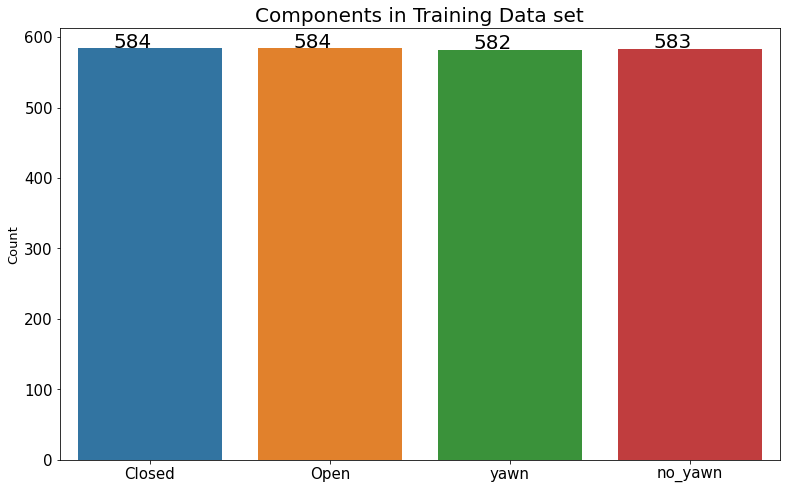

Number of data points in class Open = 584(25.0321%) of training set
Number of data points in class Closed = 584(25.0321%) of training set
Number of data points in class no_yawn = 583(24.9893%) of training set
Number of data points in class yawn = 582(24.9464%) of training set
--------------------------------------------------------------------------------


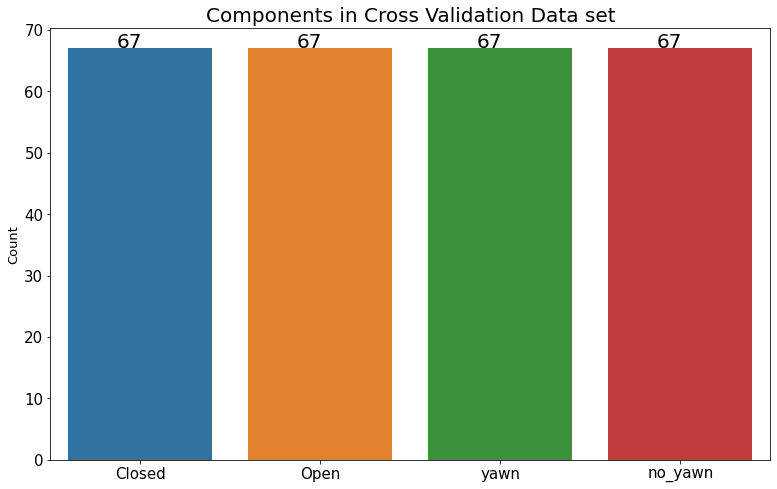

Number of data points in class yawn = 67(25.0%) of cross validation set
Number of data points in class Open = 67(25.0%) of cross validation set
Number of data points in class no_yawn = 67(25.0%) of cross validation set
Number of data points in class Closed = 67(25.0%) of cross validation set
--------------------------------------------------------------------------------


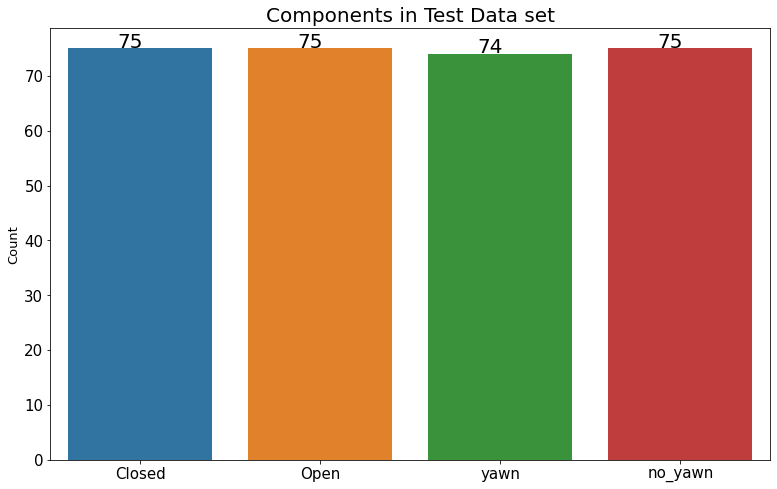

Number of data points in class Open = 75(25.0836%) of test set
Number of data points in class no_yawn = 75(25.0836%) of test set
Number of data points in class Closed = 75(25.0836%) of test set
Number of data points in class yawn = 74(24.7492%) of test set


In [ ]:
# plotting  and printing distribution of each class in all train, cross validation and test set

# for training data.................................................................................................................
fig = plt.figure(figsize = (10, 6))
ax = fig.add_axes([0,0,1,1])
ax.set_title("Components in Training Data set", fontsize = 20)
sns.countplot(x = "Component", data = df_temp_train_data_detail)
for i in ax.patches:
    ax.text(x = i.get_x() + 0.2, y = i.get_height()+1.5, s = str(i.get_height()), fontsize = 20, color = "black")
plt.xlabel("")
plt.ylabel("Count", fontsize = 13)
plt.tick_params(labelsize = 15)
plt.xticks(rotation = 0)
plt.show()
for i in train_data_detail_distribution_sorted:
    print("Number of data points in class "+str(i[0])+" = "+str(i[1])+ "("+str(np.round(((i[1]/df_temp_train_data_detail.shape[0])*100), 4))+"%)"+ " of training set")
print("-"*80)

# for cross validation data............................................................................................................
fig = plt.figure(figsize = (10, 6))
ax = fig.add_axes([0,0,1,1])
ax.set_title("Components in Cross Validation Data set", fontsize = 20)
sns.countplot(x = "Component", data = df_temp_cv_data_detail)
for i in ax.patches:
    ax.text(x = i.get_x() + 0.27, y = i.get_height()+0.2, s = str(i.get_height()), fontsize = 20, color = "black")
plt.xlabel("")
plt.ylabel("Count", fontsize = 13)
plt.tick_params(labelsize = 15)
plt.xticks(rotation = 0)
plt.show()
for i in cv_data_detail_distribution_sorted:
    print("Number of data points in class "+str(i[0])+" = "+str(i[1])+ "("+str(np.round(((i[1]/df_temp_cv_data_detail.shape[0])*100), 4))+"%)"+ " of cross validation set")
print("-"*80)

# for test data............................................................................................................................
fig = plt.figure(figsize = (10, 6))
ax = fig.add_axes([0,0,1,1])
ax.set_title("Components in Test Data set", fontsize = 20)
sns.countplot(x = "Component", data = df_temp_test_data_detail)
for i in ax.patches:
    ax.text(x = i.get_x() + 0.27, y = i.get_height()+0.2, s = str(i.get_height()), fontsize = 20, color = "black")
plt.xlabel("")
plt.ylabel("Count", fontsize = 13)
plt.tick_params(labelsize = 15)
plt.xticks(rotation = 0)
plt.show()
for i in test_data_detail_distribution_sorted:
    print("Number of data points in class "+str(i[0])+" = "+str(i[1])+ "("+str(np.round(((i[1]/df_temp_test_data_detail.shape[0])*100), 4))+"%)"+ " of test set")

As we can see the data is very well balanced and hence there is no need to balance it further. (NOTE : models trained on unbalanced datasets often have poor results when they have to generalize (predict a class or classify unseen observations. Just by predicting the majority class, models would score high on their loss-functions)

##**We will now create features for our model from grey scale images. The size of features will be (128,128,1)**

In [ ]:
# First of all we will create matrix form of our label data from all training , cv and test set so that it can be used in furthur while using softmax
df_train_data_detail_Labels = pd.get_dummies(df_train_data_detail["Label"]).values
df_cv_data_detail_Labels = pd.get_dummies(df_cv_data_detail["Label"]).values
df_test_data_detail_Labels = pd.get_dummies(df_test_data_detail["Label"]).values

# Initializing global variables to train, validate and test in batch
Batch_train_pointer = 0
Batch_cv_pointer = 0
Batch_test_pointer = 0

In [ ]:
# Function to define batches and creating numerical dataset with train data detail
def Batch_train(batch_size):
    # Global variable to keep track of data that has been been used till now
    global Batch_train_pointer
    batch_images = []
    batch_labels = []
    for i in range(batch_size):
        path1 = df_train_data_detail.iloc[Batch_train_pointer + i]["folderName"]
        path2 = df_train_data_detail.iloc[Batch_train_pointer + i]["imageName"]
        image = cv2.imread(os.path.join(path1, path2))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image = cv2.resize(image, (128, 128))
        # here, we are normalizing the images
        norm_image = image/255.0 
        # Creating and saving each image in the form of numerical data in an array 
        batch_images.append(norm_image)
        # appending corresponding labels 
        batch_labels.append(df_train_data_detail_Labels[Batch_train_pointer + i]) 
        
    Batch_train_pointer += batch_size
    return np.array(batch_images), np.array(batch_labels)

In [ ]:
# Already I have made two folders namely combined_train and combined_train_labels in my current working directory which will be used furthur to save features and labels for training data
save_dir = "../content/drive/My Drive/Project_new/Generated/combined_train/"
save_dir_labels = "../content/drive/My Drive/Project_new/Generated/combined_train_labels/"
batch_size = 16
for i in range(int(len(df_train_data_detail)/batch_size)):
    # Loading and saving Batch images and labels with the help of function Batch_train that we created above
    x, y = Batch_train(batch_size)
    # saving labels in working directory
    np.save(os.path.join(save_dir_labels, "bottleneck_labels_train_{}".format(i+1)), y)
    # Creating and saving features for each batch
    np.save(os.path.join(save_dir, "bottleneck_features_train_{}".format(i+1)), x)

In [ ]:
# Function to define batches and creating numerical dataset with train data detail
def Batch_cv(batch_size):
    # Global variable to keep track of data that has been been used till now
    global Batch_cv_pointer
    batch_images = []
    batch_labels = []
    for i in range(batch_size):
        path1 = df_cv_data_detail.iloc[Batch_cv_pointer + i]["folderName"].replace("train","Generated")
        path2 = df_cv_data_detail.iloc[Batch_cv_pointer + i]["imageName"]
        image = cv2.imread(os.path.join(path1, path2))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image = cv2.resize(image, (128, 128))
        # here, we are normalizing the images
        norm_image = image/255.0 
        # Creating and saving each image in the form of numerical data in an array 
        batch_images.append(norm_image)
        # appending corresponding labels 
        batch_labels.append(df_cv_data_detail_Labels[Batch_cv_pointer + i]) 
        
    Batch_cv_pointer += batch_size
    return np.array(batch_images), np.array(batch_labels)

In [ ]:
# Already I have made two folders namely combined_train and combined_train_labels in my current working directory which will be used furthur to save features and labels for training data
save_dir = "../content/drive/My Drive/Project_new/Generated/combined_cv/"
save_dir_labels = "../content/drive/My Drive/Project_new/Generated/combined_cv_labels/"
batch_size = 16
for i in range(int(len(df_cv_data_detail)/batch_size)):
    # Loading and saving Batch images and labels with the help of function Batch_train that we created above
    x, y = Batch_cv(batch_size)
    # saving labels in working directory
    np.save(os.path.join(save_dir_labels, "bottleneck_labels_cv_{}".format(i+1)), y)
    # Creating and saving features for each batch
    np.save(os.path.join(save_dir, "bottleneck_features_cv_{}".format(i+1)), x)

In [ ]:
# Function to define batches and creating numerical dataset with train data detail
def Batch_test(batch_size):
    # Global variable to keep track of data that has been been used till now
    global Batch_test_pointer
    batch_images = []
    batch_labels = []
    for i in range(batch_size):
        path1 = df_test_data_detail.iloc[Batch_test_pointer + i]["folderName"].replace("train","Generated")
        path2 = df_test_data_detail.iloc[Batch_test_pointer + i]["imageName"]
        image = cv2.imread(os.path.join(path1, path2))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image = cv2.resize(image, (128, 128))
        # here, we are normalizing the images
        norm_image = image/255.0 
        # Creating and saving each image in the form of numerical data in an array 
        batch_images.append(norm_image)
        # appending corresponding labels 
        batch_labels.append(df_test_data_detail_Labels[Batch_test_pointer + i]) 
        
    Batch_test_pointer += batch_size
    return np.array(batch_images), np.array(batch_labels)

In [ ]:
# Already I have made two folders namely combined_train and combined_train_labels in my current working directory which will be used furthur to save features and labels for training data
save_dir = "../content/drive/My Drive/Project_new/Generated/combined_test/"
save_dir_labels = "../content/drive/My Drive/Project_new/Generated/combined_test_labels/"
batch_size = 16
for i in range(int(len(df_test_data_detail)/batch_size)):
    # Loading and saving Batch images and labels with the help of function Batch_train that we created above
    x, y = Batch_test(batch_size)
    # saving labels in working directory
    np.save(os.path.join(save_dir_labels, "bottleneck_labels_test_{}".format(i+1)), y)
    # Creating and saving features for each batch
    np.save(os.path.join(save_dir, "bottleneck_features_test_{}".format(i+1)), x)

## **Model learning with some modifications in Lenet5 model**

Since our aim also include real time prediction so, our model should be small (so that it can be faster while predicting). To accomplish it we can use lenet-5 model which is one of the smallest CNN architecture with some minor modifications.

LeNet is a convolutional neural network structure proposed by Yann LeCun et al. in 1998. In general, LeNet refers to lenet-5 and is a simple convolutional neural network. Convolutional neural networks are a kind of feed-forward neural network whose artificial neurons can respond to a part of the surrounding cells in the coverage range and perform well in large-scale image processing.

It was one of the earliest convolutional neural networks and promoted the development of deep learning. Since 1988, after years of research and many successful iterations, the pioneering work has been named LeNet5.

The standard architecture of Lenet5 is:

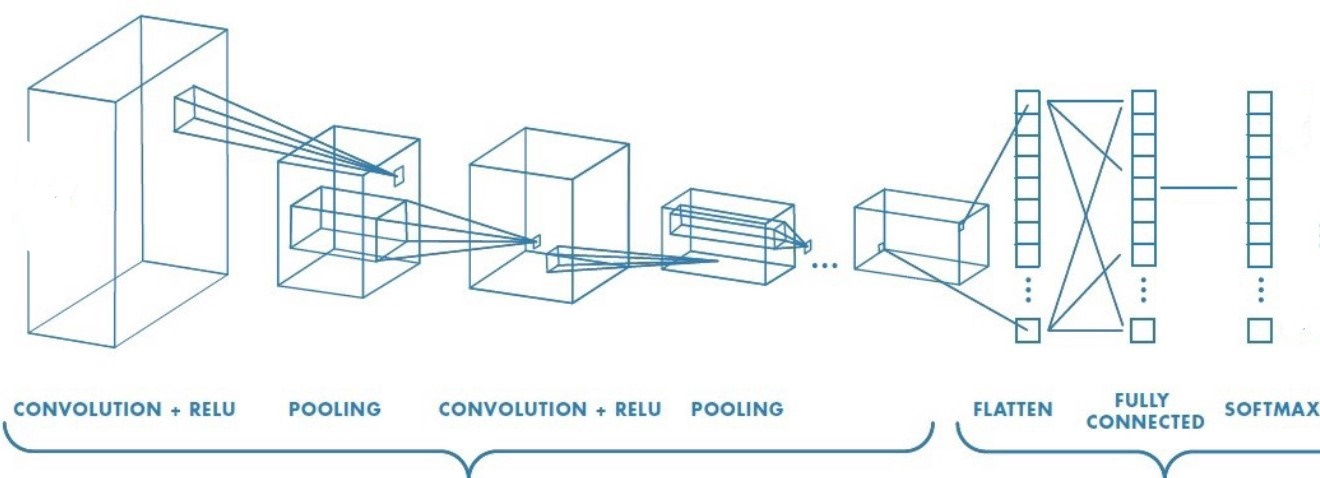

In the model, we will use an input image of shape (128,128,1) with an additional 3rd layer of CNN and a dropout of 0.6 with fully connected layer.

The image of size (128,128,1) will be able to capture features associated with both yawning and closed/Open eyes because this size is not too big or not too small.

##**Modelling, training and saving the trained model**

In [ ]:
classes_number = 4

# Now we will define our letnet5 model with some modifications as specified above (A 3rd layer of CNN in extra and a dropout of 0.6 with fully connected layer)
def model():
    model = Sequential()

    model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', input_shape=(128, 128, 1)))
    model.add(AveragePooling2D())

    model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu'))
    model.add(AveragePooling2D())

    model.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu'))
    model.add(AveragePooling2D())

    model.add(Flatten())

    model.add(Dense(units=120, activation='relu'))
    model.add(Dropout(0.6))
  
    model.add(Dense(60, activation='relu'))
    model.add(Dense(classes_number, activation='softmax')) 
    
    return model

In [ ]:
# Now we will train our model by extracting features from drive that we have saved earlier

# Directory for training features and labels
save_dir_combined_train = "../content/drive/My Drive/Project_new/Generated/combined_train/"
save_dir_comb_train_labels = "../content/drive/My Drive/Project_new/Generated/combined_train_labels/"

# Directory for cross validating features and labels
save_dir_combined_cv = "../content/drive/My Drive/Project_new/Generated/combined_cv/"
save_dir_comb_cv_labels = "../content/drive/My Drive/Project_new/Generated/combined_cv_labels/"

# Directory for testing features and labels
save_dir_combined_test = "../content/drive/My Drive/Project_new/Generated/combined_test/"
save_dir_comb_test_labels = "../content/drive/My Drive/Project_new/Generated/combined_test_labels/"

# Directory to save results from our model
saver = "../content/drive/My Drive/Project_new/Generated/"

model = model()
model.summary()
model.compile(loss = 'categorical_crossentropy', optimizer = "adam", metrics = ["accuracy"])

epochs = 50
batch_size = 16
step = 0

# defining the no of examples in each batch and defining list to store losses and accuracy
Train_bottleneck_files = int(len(df_train_data_detail) / batch_size) 
CV_bottleneck_files = int(len(df_cv_data_detail) / batch_size)
epoch_number, CombTrain_loss, CombTrain_acc, CV_loss, CV_acc = [], [], [], [], []

for epoch in range(epochs):
    #  defining average losses and accuracy for training and cv set over all the examples that makes one epoch
    avg_epoch_CombTr_loss, avg_epoch_CombTr_acc, avg_epoch_CV_loss, avg_epoch_CV_acc = 0, 0, 0, 0
    epoch_number.append(epoch + 1)
    
    # training over each example within a epoch
    for i in range(Train_bottleneck_files):
        step = step + 1

        # loading batch of train bottleneck features for training multilayer perceptron.
        X_CombTrain_load = np.load(os.path.join(save_dir_combined_train, "bottleneck_features_train_{}.npy".format(i+1)))
        X_CombTrain_load = X_CombTrain_load.reshape( X_CombTrain_load.shape[0], X_CombTrain_load.shape[1], X_CombTrain_load.shape[2], 1)
        Y_CombTrain = np.load(os.path.join(save_dir_comb_train_labels, "bottleneck_labels_train_{}.npy".format(i+1)))

        # loading batch of CV bottleneck features for cross-validation.
        X_CV_load = np.load(os.path.join(save_dir_combined_cv, "bottleneck_features_cv_{}.npy".format((i % CV_bottleneck_files) + 1)))
        X_CV_load = X_CV_load.reshape( X_CV_load.shape[0], X_CV_load.shape[1], X_CV_load.shape[2], 1)
        Y_CV = np.load(os.path.join(save_dir_comb_cv_labels, "bottleneck_labels_cv_{}.npy".format((i % CV_bottleneck_files) + 1)))
        
        # train the model on train batch
        CombTrain_Loss, CombTrain_Accuracy = model.train_on_batch(X_CombTrain_load, Y_CombTrain) 
        # cross validate the model on CV batch
        CV_Loss, CV_Accuracy = model.test_on_batch(X_CV_load, Y_CV)

        print("Epoch: {}, Step: {}, CombTr_Loss: {}, CombTr_Acc: {}, CV_Loss: {}, CV_Acc: {},".format(epoch+1, step, np.round(float(CombTrain_Loss), 2), np.round(float(CombTrain_Accuracy), 2), np.round(float(CV_Loss), 2), np.round(float(CV_Accuracy), 2)))
        
        avg_epoch_CombTr_loss += CombTrain_Loss / Train_bottleneck_files
        avg_epoch_CombTr_acc += CombTrain_Accuracy / Train_bottleneck_files
        avg_epoch_CV_loss += CV_Loss / Train_bottleneck_files
        avg_epoch_CV_acc += CV_Accuracy / Train_bottleneck_files
        
    print("Avg_CombTrain_Loss: {}, Avg_CombTrain_Acc: {}, Avg_CV_Loss: {}, Avg_CV_Acc: {}".format(np.round(float(avg_epoch_CombTr_loss), 2), np.round(float(avg_epoch_CombTr_acc), 2), np.round(float(avg_epoch_CV_loss), 2), np.round(float(avg_epoch_CV_acc), 2)))

    CombTrain_loss.append(avg_epoch_CombTr_loss)
    CombTrain_acc.append(avg_epoch_CombTr_acc)
    CV_loss.append(avg_epoch_CV_loss)
    CV_acc.append(avg_epoch_CV_acc)
    
    # saving the model on each epoc
    model.save(os.path.join(saver, "model.h5"))  
    # saving the weights of model on each epoch
    model.save_weights(os.path.join(saver, "model_weights.h5")) 
    print("Model and weights saved at epoch {}".format(epoch + 1)) 

Streaming output truncated to the last 5000 lines.
Avg_CombTrain_Loss: 0.19, Avg_CombTrain_Acc: 0.91, Avg_CV_Loss: 0.2, Avg_CV_Acc: 0.91
Model and weights saved at epoch 16
Epoch: 17, Step: 2321, CombTr_Loss: 0.19, CombTr_Acc: 0.88, CV_Loss: 0.11, CV_Acc: 1.0,
Epoch: 17, Step: 2322, CombTr_Loss: 0.41, CombTr_Acc: 0.81, CV_Loss: 0.36, CV_Acc: 0.88,
Epoch: 17, Step: 2323, CombTr_Loss: 0.11, CombTr_Acc: 1.0, CV_Loss: 0.28, CV_Acc: 0.88,
Epoch: 17, Step: 2324, CombTr_Loss: 0.07, CombTr_Acc: 1.0, CV_Loss: 0.18, CV_Acc: 0.94,
Epoch: 17, Step: 2325, CombTr_Loss: 0.12, CombTr_Acc: 0.94, CV_Loss: 0.21, CV_Acc: 0.88,
Epoch: 17, Step: 2326, CombTr_Loss: 0.34, CombTr_Acc: 0.81, CV_Loss: 0.12, CV_Acc: 0.94,
Epoch: 17, Step: 2327, CombTr_Loss: 0.25, CombTr_Acc: 0.81, CV_Loss: 0.09, CV_Acc: 1.0,
Epoch: 17, Step: 2328, CombTr_Loss: 0.16, CombTr_Acc: 0.94, CV_Loss: 0.47, CV_Acc: 0.88,
Epoch: 17, Step: 2329, CombTr_Loss: 0.33, CombTr_Acc: 0.81, CV_Loss: 0.1, CV_Acc: 1.0,
Epoch: 17, Step: 2330, CombTr_Lo

##**printing and plotting the accuracy and loss of training set and cross validation set**

In [ ]:
# printing a table depicting the detail about the trained model
log_frame = pd.DataFrame(columns = ["Epoch", "Comb_Train_Loss", "Comb_Train_Accuracy", "CV_Loss", "CV_Accuracy"])
log_frame["Epoch"] = epoch_number
log_frame["Comb_Train_Loss"] = CombTrain_loss
log_frame["Comb_Train_Accuracy"] = CombTrain_acc
log_frame["CV_Loss"] = CV_loss
log_frame["CV_Accuracy"] = CV_acc
log_frame.to_csv("../content/drive/My Drive/Project_new/Generated/Log.csv", index = False)   

log = pd.read_csv("../content/drive/My Drive/Project_new/Generated/Log.csv")
log

,Epoch,Comb_Train_Loss,Comb_Train_Accuracy,CV_Loss,CV_Accuracy
0,1,0.912091,0.550000,0.828189,0.623276
1,2,0.536606,0.749569,0.481157,0.761638
2,3,0.441140,0.773276,0.381791,0.813793
3,4,0.403603,0.804310,0.337699,0.833621
4,5,0.365258,0.815086,0.325234,0.829741
5,6,0.337798,0.830603,0.310864,0.840517
6,7,0.311266,0.843103,0.293288,0.848276
7,8,0.305092,0.851724,0.295948,0.850000
8,9,0.291419,0.866379,0.276727,0.868103
9,10,0.267524,0.865948,0.260420,0.871552


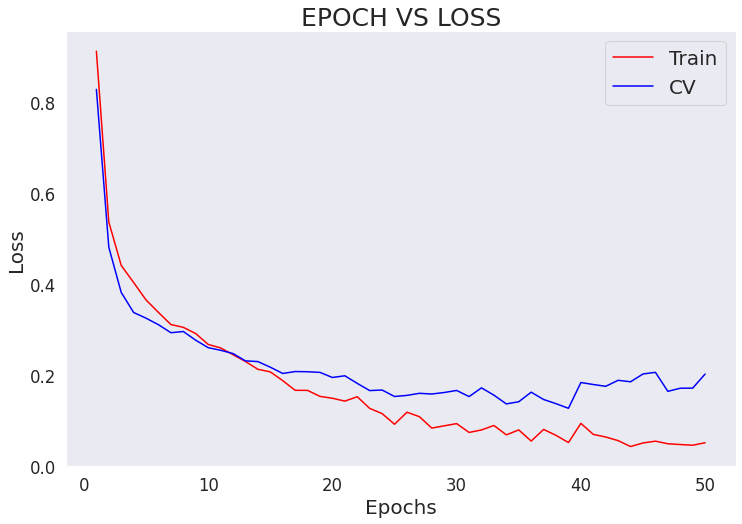

In [ ]:
# plotting epoch vs loss
def plotting(epoch, train_loss, CV_loss, title):
    fig, axes = plt.subplots(1,1, figsize = (12, 8))
    axes.plot(epoch, train_loss, color = 'red', label = "Train")
    axes.plot(epoch, CV_loss, color = 'blue', label = "CV")
    axes.set_title(title, fontsize = 25)
    axes.set_xlabel("Epochs", fontsize = 20)
    axes.set_ylabel("Loss", fontsize = 20)
    axes.grid()
    axes.legend(fontsize = 20)

plotting(list(log["Epoch"]), list(log["Comb_Train_Loss"]), list(log["CV_Loss"]), "EPOCH VS LOSS") 

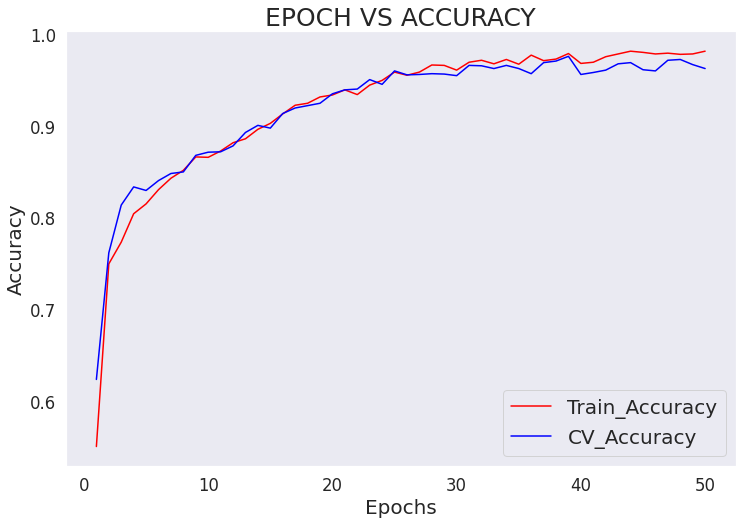

In [ ]:
# plotting epoch vs accuracy
def plotting(epoch, train_acc, CV_acc, title):
    fig, axes = plt.subplots(1,1, figsize = (12, 8))
    axes.plot(epoch, train_acc, color = 'red', label = "Train_Accuracy")
    axes.plot(epoch, CV_acc, color = 'blue', label = "CV_Accuracy")
    axes.set_title(title, fontsize = 25)
    axes.set_xlabel("Epochs", fontsize = 20)
    axes.set_ylabel("Accuracy", fontsize = 20)
    axes.grid()
    axes.legend(fontsize = 20)

plotting(list(log["Epoch"]), list(log["Comb_Train_Accuracy"]), list(log["CV_Accuracy"]), "EPOCH VS ACCURACY")    

##**Evaluating test accuracy**

In [ ]:
def print_confusion_matrix(Y_Test_Labels, Predicted_Labels):
    
    # Defining confusion matrix
    confusionMatx = confusion_matrix(Y_Test_Labels, Predicted_Labels)
    precision = confusionMatx/confusionMatx.sum(axis = 0)
    recall = (confusionMatx.T/confusionMatx.sum(axis = 1)).T
    sns.set(font_scale=1.5)
    labels = ["CLOSED", "OPEN", "YAWN", "NO YAWN"]
    
    # plotting confusion matrix
    plt.figure(figsize=(16,7))
    sns.heatmap(confusionMatx, cmap = "Blues", annot = True, fmt = ".1f", xticklabels=labels, yticklabels=labels)
    plt.title("Confusion Matrix", fontsize = 30)
    plt.xlabel('Predicted Class', fontsize = 20)
    plt.ylabel('Original Class', fontsize = 20)
    plt.tick_params(labelsize = 15)
    plt.xticks(rotation = 90)
    plt.show()

    # -------------------------------------------------------------------------------------------------------
    print("-"*125)

    plt.figure(figsize=(16,7))
    sns.heatmap(precision, cmap = "Blues", annot = True, fmt = ".2f", xticklabels=labels, yticklabels=labels)
    plt.title("Precision Matrix", fontsize = 30)
    plt.xlabel('Predicted Class', fontsize = 20)
    plt.ylabel('Original Class', fontsize = 20)
    plt.tick_params(labelsize = 15)
    plt.xticks(rotation = 90)
    plt.show()
    
    # -----------------------------------------------------------------------------------------------------------
    print("-"*125)
    
    plt.figure(figsize=(16,7))
    sns.heatmap(recall, cmap = "Blues", annot = True, fmt = ".2f", xticklabels=labels, yticklabels=labels)
    plt.title("Recall Matrix", fontsize = 30)
    plt.xlabel('Predicted Class', fontsize = 20)
    plt.ylabel('Original Class', fontsize = 20)
    plt.tick_params(labelsize = 15)
    plt.xticks(rotation = 90)
    plt.show()

In [ ]:
# Loading the model
component_dict = {1:"CLOSED", 2:"OPEN", 3:"YAWN", 4:"NO YAWN"}
model_trained = load_model("../content/drive/My Drive/Project_new/Generated/model.h5")

**PREDICTION WITH STILL IMAGES**

In [ ]:
# Now we will define a function which is going to take thre path of both the images(Original and extracted one) and as a result will give us class to which it belongs
def prediction(path1,path2):

    # converting image to gray scale, resizing it and then save it
    img1 = cv2.imread(path1)
    gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    cv2.imwrite("/content/original_Image.jpg", cv2.resize(gray1, (128, 128)))
    img2 = cv2.imread(path2)
    gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
    cv2.imwrite(path2, cv2.resize(img2, (128, 128)))

    # read the processed image then make prediction and display the result
    image1 = cv2.imread("/content/original_Image.jpg")
    image1 = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
    image1 = image1.reshape( image1.shape[0], image1.shape[1], 1)
    image1= image1.reshape(1, image1.shape[0], image1.shape[1], image1.shape[2])
    # normalizing the image
    final_image1 = image1/255.0 
    # making prediction from our own model.
    pred1 = model_trained.predict(final_image1)  
    component_label1 = pred1[0][2:].argmax() + 3
    print(".......................Predicted Expression Probabilities for original image...................")
    print("YAWN: {}\nNO YAWN: {}".format(pred1[0][2], pred1[0][3]))
    print("Dominant Probability = "+str(component_dict[component_label1])+": "+str(max(pred1[0][2:])))
    print("\n##########################################\n")
    image2 = cv2.imread(path2)
    image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)
    image2 = image2.reshape( image2.shape[0], image2.shape[1], 1)
    image2 = image2.reshape(1, image2.shape[0], image2.shape[1], image2.shape[2])
    # normalizing the image
    final_image2 = image2/255.0 
    # making prediction from our own model.
    pred2 = model_trained.predict(final_image2)  
    component_label2 = pred2[0][:2].argmax() + 1
    print(".......................Predicted Expression Probabilities for extracted image...................")
    print("CLOSED: {}\nOPEN: {}".format(pred2[0][0], pred2[0][1]))
    print("Dominant Probability = "+str(component_dict[component_label2])+": "+str(max(pred2[0][:2])))

    if str(component_dict[component_label2]) == 'CLOSED':
      print("\nPERSON IS SLEEPY")
    else:
      if  str(component_dict[component_label1]) == 'YAWN':
        print("\nPERSON IS SLEEPY") 
      else:
        print("\nPERSON IS NOT SLEEPY")  

Enter the path of Image file  /content/Test5.jpg
                                               
######################################### THE IMAGE GIVEN ######################################################


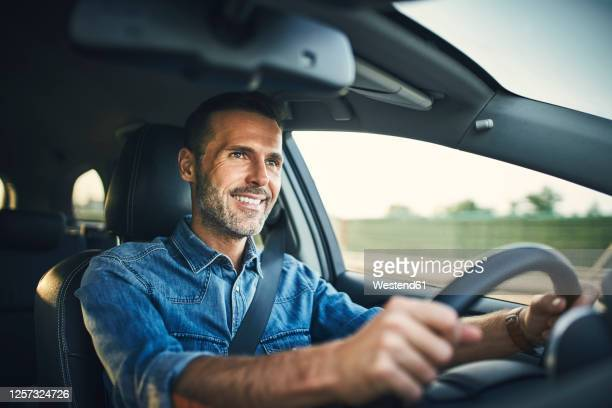

.......................Predicted Expression Probabilities for original image...................
YAWN: 0.10909208655357361
NO YAWN: 0.8909078240394592
Dominant Probability = NO YAWN: 0.8909078

##########################################

.......................Predicted Expression Probabilities for extracted image...................
CLOSED: 1.1750834971735458e-08
OPEN: 5.741875952480768e-08
Dominant Probability = OPEN: 5.741876e-08

PERSON IS NOT SLEEPY


In [ ]:
# Taking the path of saved Image as input, extracting second image from it and predicting the results

# Readng the image
path1 = input('Enter the path of Image file  ')
print('                                               ')
Image = cv2.imread(path1)

# Extracting second image from it
path2 = '/content/extracted_image.jpg'
print("######################################### THE IMAGE GIVEN ######################################################")
cv2_imshow(Image)
face_cascade = cv2.CascadeClassifier('haarcascade_lefteye_2splits.xml') 
gray = cv2.cvtColor(Image, cv2.COLOR_BGR2GRAY)
eyes = face_cascade.detectMultiScale(gray)
if len(eyes)>0:
  for (x,y,w,h) in eyes:
      #cropping the face in image
      image = gray[y:y+h, x:x+w] 
      # resizing image then saving it 
      image = cv2.resize(image, (128, 128))
      cv2.imwrite(path2, image)
      break
else:
      image = cv2.resize(gray, (128, 128))
      cv2.imwrite(path2, image)      

# Prediction
prediction(path1,path2) 

**PREDICTION WITH WEBCAM**

In [ ]:
def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

In [ ]:
# Function which is going to use captured image and will use that image for prediction
def return_prediction():
    # path of captured image
    path1 = "../content/photo.jpg"
    #converting image to gray scale and save it
    img = cv2.imread(path1)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # saving gray version of captured image
    cv2.imwrite(path1, gray)
    
    #detect eyes in image, crop it then resize it then save it
    path2 = "../content/extracted_photo.jpg"
    face_cascade = cv2.CascadeClassifier('haarcascade_lefteye_2splits.xml') 
    img = cv2.imread(path1)
    eyes = face_cascade.detectMultiScale(img)
    if len(eyes)>0:
       for (x,y,w,h) in eyes:
          #cropping the face in image
          image = img[y:y+h, x:x+w] 
          # resizing image then saving it 
          image = cv2.resize(image, (128, 128))
          cv2.imwrite(path2, image)
          break
    else:
       img = cv2.resize(img, (128, 128))
       cv2.imwrite(path2, img)
    
    # converting image to gray scale, resizing it and then save it
    img1 = cv2.imread(path1)
    gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    cv2.imwrite(path1, cv2.resize(gray1, (128, 128)))
    img2 = cv2.imread(path2)
    gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
    cv2.imwrite(path2, cv2.resize(img2, (128, 128)))

    # read the processed image then make prediction and display the result
    image1 = cv2.imread(path1)
    image1 = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
    image1 = image1.reshape( image1.shape[0], image1.shape[1], 1)
    image1= image1.reshape(1, image1.shape[0], image1.shape[1], image1.shape[2])
    # normalizing the image
    final_image1 = image1/255.0 
    # making prediction from our own model.
    pred1 = model_trained.predict(final_image1)  
    component_label1 = pred1[0][2:].argmax() + 3
    image2 = cv2.imread(path2)
    image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)
    image2 = image2.reshape( image2.shape[0], image2.shape[1], 1)
    image2 = image2.reshape(1, image2.shape[0], image2.shape[1], image2.shape[2])
    # normalizing the image
    final_image2 = image2/255.0 
    # making prediction from our own model.
    pred2 = model_trained.predict(final_image2)  
    component_label2 = pred2[0][:2].argmax() + 1

    if str(component_dict[component_label2]) == 'CLOSED':
      print("\nPERSON IS SLEEPY")
    else:
      if  str(component_dict[component_label1]) == 'YAWN':
        print("\nPERSON IS SLEEPY") 
      else:
        print("\nPERSON IS NOT SLEEPY")  

In [ ]:
# Function which will call the take_photo and hence will make prediction
def webcam_prediction():
    from IPython.display import Image
    try:
      # Opening webcam with a capture button at top
      filename = take_photo()
      # Show the image which was just taken.
      display(Image(filename))
    except Exception as err:
      # Errors will be thrown if the user does not have a webcam or if they do not
      # grant the page permission to access it.
      print(str(err))

    # make prediction from that image  
    return_prediction()
    print('..........................................................................................................')
    # Ask the user again if he want to have more predictions
    user = input('Do you want another prediction ? Answer in No or Yes   ')
    if user == 'Yes':
      webcam_prediction()
    else:
      print('..........................................................................................................')

**PREDICTION IN REAL TIME**


In [ ]:
# JavaScript to properly create our live video stream using our webcam as input
def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;
    
    var pendingResolve = null;
    var shutdown = false;
    
    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }
    
    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }
    
    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);
      
      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);
           
      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);
      
      const instruction = document.createElement('div');
      instruction.innerHTML = 
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };
      
      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640; //video.videoWidth;
      captureCanvas.height = 480; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);
      
      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();
      
      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }
            
      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }
      
      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;
      
      return {'create': preShow - preCreate, 
              'show': preCapture - preShow, 
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)
  
def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data

In [ ]:
# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

In [ ]:
def return_prediction2(path1):
    #converting image to gray scale and save it
    img = cv2.imread(path1)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    cv2.imwrite(path1, gray)

    #detect eyes in image, crop it then resize it then save it
    path2 = "../content/extracted_photo_real_time.jpg"
    face_cascade = cv2.CascadeClassifier('haarcascade_lefteye_2splits.xml') 
    img = cv2.imread(path1)
    eyes = face_cascade.detectMultiScale(img)
    if len(eyes)>0:
       for (x,y,w,h) in eyes:
          #cropping the face in image
          image = img[y:y+h, x:x+w] 
          # resizing image then saving it 
          image = cv2.resize(image, (128, 128))
          cv2.imwrite(path2, image)
          break
    else:
       image = cv2.resize(img, (128, 128))
       cv2.imwrite(path2, image)
    
    # converting image to gray scale, resizing it and then save it
    img1 = cv2.imread(path1)
    gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    cv2.imwrite(path1, cv2.resize(gray1, (128, 128)))
    img2 = cv2.imread(path2)
    gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
    cv2.imwrite(path2, cv2.resize(img2, (128, 128)))

    # read the processed image then make prediction and display the result
    image1 = cv2.imread(path1)
    image1 = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
    image1 = image1.reshape( image1.shape[0], image1.shape[1], 1)
    image1= image1.reshape(1, image1.shape[0], image1.shape[1], image1.shape[2])
    # normalizing the image
    final_image1 = image1/255.0 
    # making prediction from our own model.
    pred1 = model_trained.predict(final_image1)  
    component_label1 = pred1[0][2:].argmax() + 3
    image2 = cv2.imread(path2)
    image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)
    image2 = image2.reshape( image2.shape[0], image2.shape[1], 1)
    image2 = image2.reshape(1, image2.shape[0], image2.shape[1], image2.shape[2])
    # normalizing the image
    final_image2 = image2/255.0 
    # making prediction from our own model.
    pred2 = model_trained.predict(final_image2)  
    component_label2 = pred2[0][:2].argmax() + 1

    if str(component_dict[component_label2]) == 'CLOSED':
      return(0)
    else:
      if  str(component_dict[component_label1]) == 'YAWN':
        return(0) 
      else:
        return(1) 

In [ ]:
# start streaming video from webcam
video_stream()
# label for video
label_html = 'Capturing...'
# initialze bounding box to empty
path = "/content/real_time_captured.jpg"
bbox = ''
result  = 100
while True:
    js_reply = video_frame(label_html, bbox)
    if result == 0:
      output.eval_js('new Audio("https://dm0qx8t0i9gc9.cloudfront.net/previews/audio/BsTwCwBHBjzwub4i4/audioblocks-digital-hud-buzzer-error-warning-alert-4_rFSQDbf8CD8_NWM.mp3").play()') 
    if not js_reply:
        break

    # convert JS response to OpenCV Image
    frame = js_to_image(js_reply["img"])
    cv2.imwrite(path, frame)

    # create transparent overlay for bounding box
    bbox_array = np.zeros([480,640,4], dtype=np.uint8)

    # call our darknet helper on video frame
    #import random
    #result = random.randint(1,50)
    result = return_prediction2(path)

    # loop through detections and draw them on transparent overlay image
    if result == 0:
       bbox_array = cv2.rectangle(bbox_array, (50, 400), (600, 450), (255,255,255) ,2)
       bbox_array = cv2.putText(bbox_array, "PERSON IS SLEEPY",(80, 435), cv2.FONT_HERSHEY_SIMPLEX, 1,(255,255,255), 2)
    else:
       bbox_array = cv2.rectangle(bbox_array, (50, 400), (600, 450), (255,255,255) ,2)
       bbox_array = cv2.putText(bbox_array, "PERSON IS NOT SLEEPY",(80, 435), cv2.FONT_HERSHEY_SIMPLEX, 1,(255,255,255), 2)

    bbox_array[:,:,3] = (bbox_array.max(axis = 2) > 0 ).astype(int) * 255
    # convert overlay of bbox into bytes
    bbox_bytes = bbox_to_bytes(bbox_array)
    # update bbox so next frame gets new overlay
    bbox = bbox_bytes
 

<IPython.core.display.Javascript object>